# HW3: Wafer Map Failure Pattern — Starter Notebook

This notebook is a scaffold that follows the assignment spec. Fill in TODOs and run top-to-bottom.

**Contents**
1. Setup & Imports  
2. (Optional) LLM Helper — ask questions from within the notebook  
3. Load & Inspect Data  
4. Visualization (one example wafer per class + export all wafers to folders)  
5. Data Prep (resize to 64×64, encode labels)  
6. Feature Engineering (salient region & 10 features)  
7. Train/Validate — Decision Tree (metrics, confusion matrices, tree plot)  
8. Train/Validate — Support Vector Classifier (metrics, confusion matrices)  
9. Test Inference + CSV Export (`dt_scores.csv`, `svc_scores.csv`)  

> Tip: You’re encouraged to call the LLM anytime you’re stuck or curious — include **all** those calls here per the homework requirements.


In [1]:
# 1) Setup & Imports
# If you get missing-package errors, install locally (e.g., pip install scikit-image matplotlib scikit-learn numpy pandas).
# Avoid seaborn per instructions.

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

# Image/feature utils
from skimage.transform import resize
from skimage.measure import label, regionprops, perimeter
from skimage.morphology import convex_hull_image
from scipy.ndimage import distance_transform_edt

# Models & metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

# For nice printing
np.set_printoptions(edgeitems=5, linewidth=120, suppress=True)

# Data paths (EDIT if your files are elsewhere)
TRAIN_NPY = Path('wafermap_train.npy')       # array of dicts (per the spec)
TEST_NPY  = Path('wafermap_test.npy')     # array of dicts for test

# Output dirs
OUT_DIR = Path('outputs')
PLOTS_DIR = OUT_DIR / 'plots'
EXPORT_DIR = OUT_DIR / 'wafer_by_class'

PLOTS_DIR.mkdir(parents=True, exist_ok=True)
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

print('Notebook ready.')


Notebook ready.


## 2) (Optional) LLM Helper

Include your **real questions** while working. You may call any LLM you like.
Below is a helper that uses the OpenAI SDK as an example. Set your API key in the environment (e.g., `export OPENAI_API_KEY=...`).

> You **won’t lose points** for simple or redundant questions — include them!


In [2]:
# Example OpenAI helper (edit/remove if you use a different provider).
# NOTE: Do NOT commit secrets. Set OPENAI_API_KEY in your environment.
# If you don't want to actually call the API now, you can still keep the cell and run later.

USE_OPENAI = False  # set to True when you're ready to make calls

def ask_llm(prompt: str, model: str = "gpt-4o-mini", temperature: float = 0.2) -> str:
    """Send a question to an LLM and return the answer as text."""
    if not USE_OPENAI:
        return "[LLM disabled] Set USE_OPENAI=True to send this prompt. Your prompt was:\n\n" + prompt
    try:
        from openai import OpenAI
        import os
        client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        resp = client.chat.completions.create(
            model=model,
            temperature=temperature,
            messages=[
                {"role": "system", "content": "You are a helpful TA for a wafer map ML project."},
                {"role": "user", "content": prompt},
            ],
        )
        return resp.choices[0].message.content
    except Exception as e:
        return f"[LLM ERROR] {e}\nPROMPT WAS:\n\n{prompt}"

# Example usage — keep these in the notebook so graders can see your questions & the answers.
example_q = """
I'm about to implement 'salient region' as the largest 8-neighborhood connected component of failing dice (value==2).
Is this definition correct for this HW? Any pitfalls (e.g., when there are multiple equally large components)?
"""
print(ask_llm(example_q))


[LLM disabled] Set USE_OPENAI=True to send this prompt. Your prompt was:


I'm about to implement 'salient region' as the largest 8-neighborhood connected component of failing dice (value==2).
Is this definition correct for this HW? Any pitfalls (e.g., when there are multiple equally large components)?



## 3) Load & Inspect Data

Per the PDF, each entry has columns: `dieSize`, `failureType`, `lotName`, `trainTestLabel`, `waferIndex`, `waferMap`.

We’ll load the `.npy` file (object array of dicts) and convert to a DataFrame for convenience.


In [3]:
def load_wafer_npy(path: Path) -> pd.DataFrame:
    arr = np.load(path, allow_pickle=True)
    print("First element example:\n", arr[0])  # confirm structure
    columns = ["dieSize", "failureType", "lotName", "trainTestLabel", "waferIndex", "waferMap"]
    df = pd.DataFrame(arr, columns=columns)
    return df

# Now run
train_df = load_wafer_npy(TRAIN_NPY)
print("Train shape:", train_df.shape)
print(train_df.head())
print(train_df.columns)
print("Classes:", sorted(train_df["failureType"].unique()))


First element example:
 (3203.0, 'Center', 'lot10006', 'Training', 5.0, array([[0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0]], dtype=uint8))
Train shape: (2746, 6)
   dieSize failureType   lotName trainTestLabel  waferIndex  \
0   3203.0      Center  lot10006       Training         5.0   
1   1250.0      Center  lot10067       Training         9.0   
2   2393.0      Center  lot10731       Training         9.0   
3   2393.0      Center  lot10742       Training        25.0   
4   2393.0      Center  lot10813       Training        12.0   

                                            waferMap  
0  [

## 4) Visualization

### 4.1 One example wafer per class


/tmp/ipython-input-2625574519.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


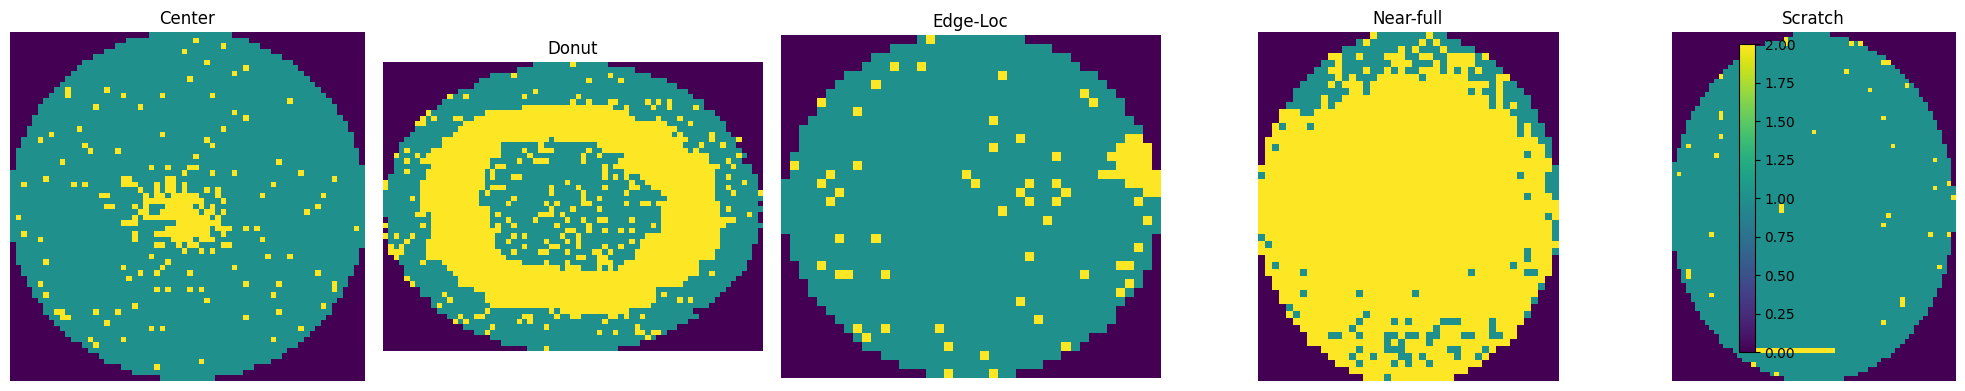

Saved: outputs/plots/example_per_class.png


In [4]:
def show_example_per_class(df: pd.DataFrame, value_key='waferMap', label_key='failureType', save_dir=PLOTS_DIR):
    classes = sorted(df[label_key].unique())
    n = len(classes)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4), squeeze=False)
    for i, c in enumerate(classes):
        ex = df[df[label_key]==c].iloc[0]
        wm = ex[value_key]
        ax = axes[0, i]
        im = ax.imshow(wm, interpolation='nearest')
        ax.set_title(c)
        ax.axis('off')
    fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02)
    fig.tight_layout()
    out = save_dir / 'example_per_class.png'
    fig.savefig(out, dpi=150)
    plt.show()
    print('Saved:', out)

show_example_per_class(train_df)

### 4.2 Export all wafers into class-named folders

This helps you click through and see patterns quickly.


In [5]:
def export_wafers_by_class(df: pd.DataFrame, root: Path = EXPORT_DIR):
    for cls in sorted(df['failureType'].unique()):
        d = root / cls
        d.mkdir(parents=True, exist_ok=True)
    for idx, row in df.iterrows():
        cls = row['failureType']
        wm = row['waferMap']
        fig = plt.figure(figsize=(3,3))
        plt.imshow(wm, interpolation='nearest')
        plt.axis('off')
        out = (root / cls) / f'wafer_{idx}.png'
        plt.savefig(out, bbox_inches='tight', pad_inches=0, dpi=120)
        plt.close(fig)
    print('Exported images to:', root)

# Uncomment to run (may take a minute)
# export_wafers_by_class(train_df)


## 5) Data Preparation (Part 1)

- **Resize** all `waferMap` arrays to `(64, 64)` using nearest-neighbor (to keep 0/1/2 labels intact).
- **Encode** `failureType` strings to numeric with `LabelEncoder`.


In [6]:
TARGET_SHAPE = (64, 64)

def resize_wafer(wm: np.ndarray, shape=TARGET_SHAPE) -> np.ndarray:
    # Use nearest-neighbor (order=0), no anti-aliasing, preserve integer labels {0,1,2}
    out = resize(wm, shape, order=0, anti_aliasing=False, preserve_range=True).astype(np.uint8)
    return out

# Preview one
_ = resize_wafer(train_df.iloc[0]['waferMap'])
print('Resize OK')

Resize OK


In [7]:
# Encode labels
le = LabelEncoder()
train_df['label_num'] = le.fit_transform(train_df['failureType'])
label_to_str = {i:s for i,s in enumerate(le.classes_)}
str_to_label = {s:i for i,s in label_to_str.items()}
print('Label mapping:', label_to_str)

Label mapping: {0: 'Center', 1: 'Donut', 2: 'Edge-Loc', 3: 'Near-full', 4: 'Scratch'}


## 6) Feature Engineering

Define **salient region** as the largest 8-connected component of failing dice (`value==2`).  
We’ll compute the required 10 features for each wafer (after resizing to 64×64).

**Wafer masks**
- `valid_mask`: cells with dice present (`waferMap > 0` → 1s and 2s)  
- `fail_mask`: cells with failing dice (`waferMap == 2`)  

**Edge band** (for Edge Yield Loss):
- compute distance-from-edge on the wafer (valid) mask, and take pixels with distance ≤ 2.


In [8]:
def compute_features_from_map(wm: np.ndarray) -> dict:
    # Ensure (64, 64)
    wm = resize_wafer(wm)
    H, W = wm.shape
    cx, cy = (W-1)/2.0, (H-1)/2.0
    wafer_radius = min(cx, cy)  # ~31.5 for 64x64 (used for ratios)

    valid_mask = (wm > 0).astype(np.uint8)
    fail_mask = (wm == 2).astype(np.uint8)

    # Yield Loss
    total_dice = int(valid_mask.sum())
    fail_dice = int(fail_mask.sum())
    yield_loss = (fail_dice / total_dice) if total_dice > 0 else 0.0

    # Edge band: distance to the "outside" of wafer (i.e., to ~edge of wafer mask)
    # Compute distance inside wafer to the complement boundary
    # For inside-distance, invert valid_mask: distance to 0 of valid? Better: distance from complement to valid boundary and compare?
    # We'll use distance transform on valid_mask==1, then define edge band where (distance <= 2.0)
    dist_inside = distance_transform_edt(valid_mask)
    edge_band = (valid_mask == 1) & (dist_inside <= 2.0)
    edge_total = int(edge_band.sum())
    edge_fail = int((edge_band & (wm == 2)).sum())
    edge_yield_loss = (edge_fail / edge_total) if edge_total > 0 else 0.0

    # Salient region (largest 8-connected component among failing dice)
    lbl = label(fail_mask, connectivity=2)  # 8-neighborhood
    if lbl.max() == 0:
        # No failing region — all features w.r.t salient region become 0
        area_ratio = 0.0
        perim_ratio = 0.0
        max_dist = 0.0
        min_dist = 0.0
        major_axis_ratio = 0.0
        minor_axis_ratio = 0.0
        solidity = 0.0
        eccentricity = 0.0
    else:
        # Find largest component
        areas = [(lbl == k).sum() for k in range(1, lbl.max()+1)]
        k_star = int(np.argmax(areas)) + 1
        salient = (lbl == k_star).astype(np.uint8)

        # Area ratio
        area = int(salient.sum())
        area_ratio = area / float(total_dice) if total_dice > 0 else 0.0

        # Perimeter ratio (perimeter over wafer radius)
        perim = perimeter(salient)

        perim_ratio = (perim / wafer_radius) if wafer_radius > 0 else 0.0

        # Distances from center
        ys, xs = np.nonzero(salient)
        dists = np.sqrt((xs - cx)**2 + (ys - cy)**2)
        max_dist = (dists.max() / wafer_radius) if dists.size > 0 and wafer_radius > 0 else 0.0
        min_dist = (dists.min() / wafer_radius) if dists.size > 0 and wafer_radius > 0 else 0.0

        # Ellipse & shape props
        props = regionprops(salient)
        if len(props) == 0:
            major_axis_ratio = 0.0
            minor_axis_ratio = 0.0
            solidity = 0.0
            eccentricity = 0.0
        else:
            rp = props[0]
            major_axis_ratio = (rp.major_axis_length / 2.0) / wafer_radius if wafer_radius > 0 else 0.0
            minor_axis_ratio = (rp.minor_axis_length / 2.0) / wafer_radius if wafer_radius > 0 else 0.0

            # Solidity via convex hull of salient region
            hull = convex_hull_image(salient.astype(bool))
            hull_area = int(hull.sum())
            solidity = (area / hull_area) if hull_area > 0 else 0.0

            eccentricity = float(rp.eccentricity)  # 0 (circle) .. 1 (line)

    feats = {
        'area_ratio': area_ratio,
        'perimeter_ratio': perim_ratio,
        'max_dist_from_center': max_dist,
        'min_dist_from_center': min_dist,
        'major_axis_ratio': major_axis_ratio,
        'minor_axis_ratio': minor_axis_ratio,
        'solidity': solidity,
        'eccentricity': eccentricity,
        'yield_loss': yield_loss,
        'edge_yield_loss': edge_yield_loss,
    }
    return feats

# Quick smoke test on one wafer
_ = compute_features_from_map(train_df.iloc[0]['waferMap'])
print('Feature function OK')

Feature function OK


In [9]:
# Build feature table for all training entries
def build_feature_table(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for i, row in df.iterrows():
        feats = compute_features_from_map(row['waferMap'])
        feats['failureType'] = row['failureType']
        feats['label_num'] = row['label_num']
        rows.append(feats)
    return pd.DataFrame(rows)

feat_df = build_feature_table(train_df)
print('Features shape:', feat_df.shape)
feat_df.head()

Features shape: (2746, 12)


,area_ratio,perimeter_ratio,max_dist_from_center,min_dist_from_center,major_axis_ratio,minor_axis_ratio,solidity,eccentricity,yield_loss,edge_yield_loss,failureType,label_num
0,0.037955,2.497237,0.404684,0.022448,0.307626,0.188053,0.566210,0.791395,0.074380,0.014815,Center,0
1,0.012218,0.891145,0.163423,0.022448,0.150053,0.114014,0.709091,0.650130,0.097118,0.220395,Center,0
2,0.004052,0.363484,0.092555,0.022448,0.102936,0.056913,0.684211,0.833249,0.040835,0.123746,Center,0
3,0.009040,0.630602,0.157135,0.022448,0.144290,0.075291,0.743590,0.853063,0.050810,0.163880,Center,0
4,0.007793,0.599984,0.163423,0.022448,0.123291,0.085873,0.714286,0.717552,0.059539,0.137124,Center,0


## 7) Train & Validate — Decision Tree

- Split train/validation using the original `trainTestLabel` if provided; otherwise do your own split.  
- **Do not normalize** features for DecisionTree.  
- Report per-class accuracy and confusion matrices (with original `failureType` labels).  
- Plot the tree to inspect feature importance/splits.


Per-class accuracy (train): {
  "Center": 0.9578606158833063,
  "Donut": 0.6774193548387096,
  "Edge-Loc": 0.970873786407767,
  "Near-full": 1.0,
  "Scratch": 0.7454545454545455
}
Per-class accuracy (valid): {
  "Center": 0.948051948051948,
  "Donut": 0.7051282051282052,
  "Edge-Loc": 0.9525862068965517,
  "Near-full": 1.0,
  "Scratch": 0.7349397590361446
}

Confusion Matrix — Train:


,Pred:Center,Pred:Donut,Pred:Edge-Loc,Pred:Near-full,Pred:Scratch
True:Center,591,0,24,0,2
True:Donut,30,210,67,0,3
True:Edge-Loc,3,7,900,0,17
True:Near-full,0,0,0,12,0
True:Scratch,3,4,77,0,246



Confusion Matrix — Valid:


,Pred:Center,Pred:Donut,Pred:Edge-Loc,Pred:Near-full,Pred:Scratch
True:Center,146,2,6,0,0
True:Donut,8,55,15,0,0
True:Edge-Loc,0,2,221,0,9
True:Near-full,0,0,0,3,0
True:Scratch,0,3,19,0,61


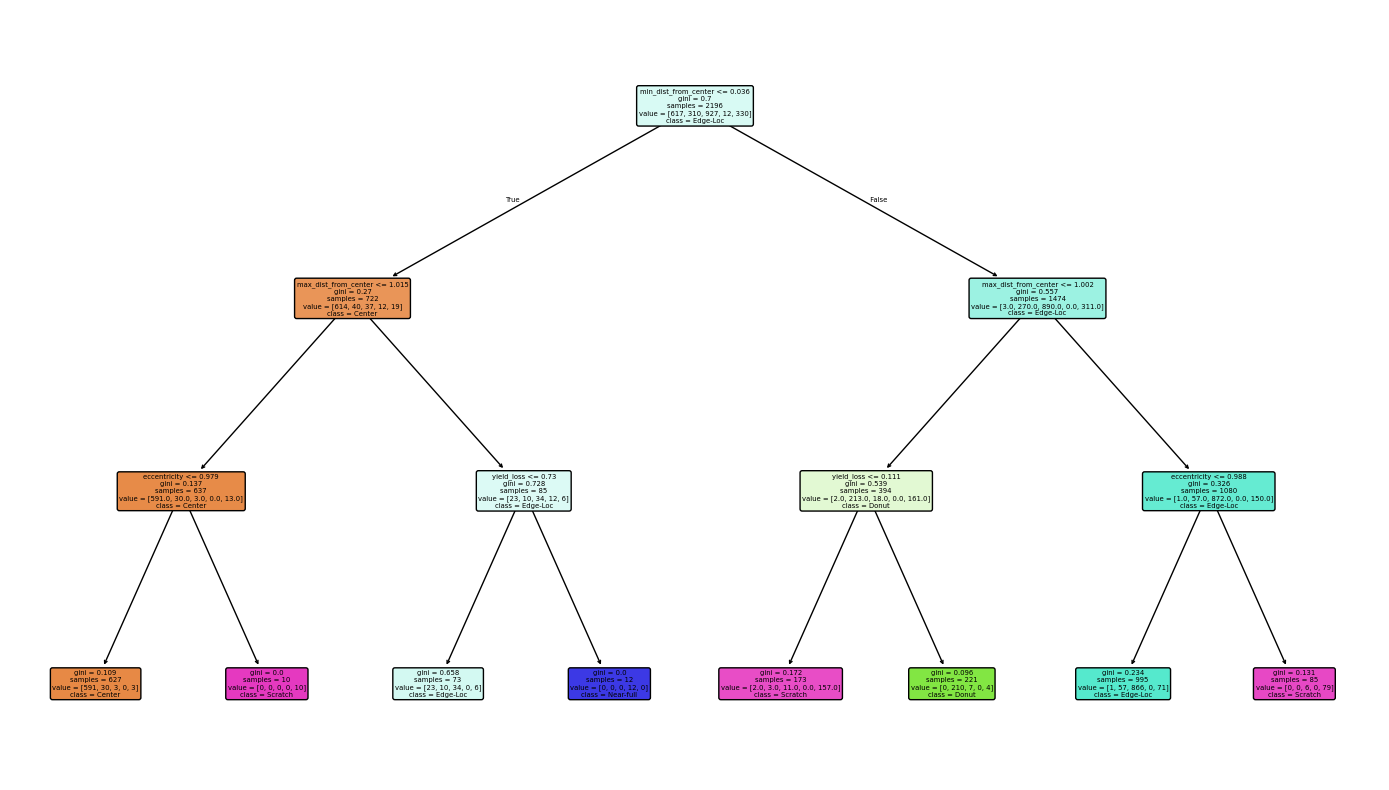

In [10]:
from sklearn.model_selection import train_test_split

# Use provided split if available; otherwise random split
if 'trainTestLabel' in train_df.columns and train_df['trainTestLabel'].nunique() > 1:
    is_train = (train_df['trainTestLabel'].values == 'Training')
    tr_idx = np.where(is_train)[0]
    va_idx = np.where(~is_train)[0]
else:
    tr_idx, va_idx = train_test_split(np.arange(len(train_df)), test_size=0.2, random_state=42, stratify=train_df['label_num'])

X = feat_df.drop(columns=['failureType', 'label_num']).values
y = feat_df['label_num'].values

X_train, X_val = X[tr_idx], X[va_idx]
y_train, y_val = y[tr_idx], y[va_idx]

dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

def per_class_accuracy(y_true, y_pred, label_to_str):
    cm = confusion_matrix(y_true, y_pred, labels=sorted(label_to_str.keys()))
    # per-class accuracy = diagonal / row sum
    accs = cm.diagonal() / np.maximum(cm.sum(axis=1), 1)
    return {label_to_str[i]: float(acc) for i, acc in enumerate(accs)}

ytr_pred = dt.predict(X_train)
yva_pred = dt.predict(X_val)

train_accs = per_class_accuracy(y_train, ytr_pred, label_to_str)
val_accs   = per_class_accuracy(y_val, yva_pred, label_to_str)

print('Per-class accuracy (train):', json.dumps(train_accs, indent=2))
print('Per-class accuracy (valid):', json.dumps(val_accs, indent=2))

# Confusion matrices labeled by original strings
def print_cm(y_true, y_pred, label_to_str):
    labels = [label_to_str[i] for i in sorted(label_to_str.keys())]
    cm = confusion_matrix(y_true, y_pred, labels=sorted(label_to_str.keys()))
    df = pd.DataFrame(cm, index=[f'True:{l}' for l in labels], columns=[f'Pred:{l}' for l in labels])
    return df

cm_train = print_cm(y_train, ytr_pred, label_to_str)
cm_val   = print_cm(y_val, yva_pred, label_to_str)

print("\nConfusion Matrix — Train:")
display(cm_train)
print("\nConfusion Matrix — Valid:")
display(cm_val)

# Tree plot
plt.figure(figsize=(14,8))
plot_tree(dt, feature_names=feat_df.drop(columns=['failureType','label_num']).columns, class_names=[label_to_str[i] for i in sorted(label_to_str.keys())], filled=True, rounded=True)
plt.tight_layout()
plt.show()

## 8) Train & Validate — Support Vector Classifier (SVC)

Per the PDF, we will **not normalize** here to keep feature scales aligned with the tree interpretation (though SVC often benefits from scaling).  
Report per-class accuracy and confusion matrices.


In [11]:
svc = SVC(kernel='rbf', C=10.0, gamma='scale', probability=False, random_state=42)
svc.fit(X_train, y_train)

ytr_pred_svc = svc.predict(X_train)
yva_pred_svc = svc.predict(X_val)

train_accs_svc = per_class_accuracy(y_train, ytr_pred_svc, label_to_str)
val_accs_svc   = per_class_accuracy(y_val, yva_pred_svc, label_to_str)

print('Per-class accuracy (train, SVC):', json.dumps(train_accs_svc, indent=2))
print('Per-class accuracy (valid, SVC):', json.dumps(val_accs_svc, indent=2))

cm_train_svc = print_cm(y_train, ytr_pred_svc, label_to_str)
cm_val_svc   = print_cm(y_val, yva_pred_svc, label_to_str)

print("\nConfusion Matrix — Train (SVC):")
display(cm_train_svc)
print("\nConfusion Matrix — Valid (SVC):")
display(cm_val_svc)

Per-class accuracy (train, SVC): {
  "Center": 0.9773095623987034,
  "Donut": 0.8580645161290322,
  "Edge-Loc": 0.970873786407767,
  "Near-full": 0.5833333333333334,
  "Scratch": 0.8939393939393939
}
Per-class accuracy (valid, SVC): {
  "Center": 0.9545454545454546,
  "Donut": 0.8076923076923077,
  "Edge-Loc": 0.978448275862069,
  "Near-full": 1.0,
  "Scratch": 0.8674698795180723
}

Confusion Matrix — Train (SVC):


,Pred:Center,Pred:Donut,Pred:Edge-Loc,Pred:Near-full,Pred:Scratch
True:Center,603,12,1,0,1
True:Donut,33,266,7,0,4
True:Edge-Loc,3,21,900,0,3
True:Near-full,3,0,2,7,0
True:Scratch,4,5,26,0,295



Confusion Matrix — Valid (SVC):


,Pred:Center,Pred:Donut,Pred:Edge-Loc,Pred:Near-full,Pred:Scratch
True:Center,147,6,1,0,0
True:Donut,11,63,3,0,1
True:Edge-Loc,1,4,227,0,0
True:Near-full,0,0,0,3,0
True:Scratch,3,1,7,0,72


## 9) Test Inference + CSV Export

Load the test `.npy`, compute features, predict with both models, and export:  
- `dt_scores.csv` and `svc_scores.csv` with **one column** `failureType` (original strings).


In [14]:
def build_feature_table_from_npy(path: Path) -> pd.DataFrame:
    arr = np.load(path, allow_pickle=True)

    # Your data structure matches: (dieSize, failureType, lotName, trainTestLabel, waferIndex, waferMap)
    columns = ["dieSize", "failureType", "lotName", "trainTestLabel", "waferIndex", "waferMap"]

    # Convert to DataFrame
    df = pd.DataFrame(arr, columns=columns)

    # Compute features
    rows = []
    for _, row in df.iterrows():
        feats = compute_features_from_map(row["waferMap"])
        rows.append(feats)

    return pd.DataFrame(rows)


    if TEST_NPY.exists():
        test_feat = build_feature_table_from_npy(TEST_NPY)
        X_test = test_feat.values

        # DT predictions
        dt_pred = dt.predict(X_test)
        dt_pred_str = [label_to_str[i] for i in dt_pred]
        pd.DataFrame({'failureType': dt_pred_str}).to_csv('dt_scores.csv', index=False)
        print('Wrote dt_scores.csv')

        # SVC predictions
        svc_pred = svc.predict(X_test)
        svc_pred_str = [label_to_str[i] for i in svc_pred]
        pd.DataFrame({'failureType': svc_pred_str}).to_csv('svc_scores.csv', index=False)
        print('Wrote svc_scores.csv')
    else:
        print('TEST_NPY not found. Place wafermap_testing.npy next to this notebook and re-run.')

## 10) (Optional) LLM Q&A Log

Use this cell (duplicate as needed) to store your questions and answers inline with context.


In [13]:
# Example usage — record your questions & answers
q1 = """Why do we prefer nearest-neighbor (order=0) when resizing wafer maps?"""
a1 = ask_llm(q1)
print('Q:', q1, '\nA:', a1, '\n')

q2 = """For 'perimeter_ratio', is dividing by wafer radius the intended normalization?"""
a2 = ask_llm(q2)
print('Q:', q2, '\nA:', a2, '\n')

# Add more as you go...


Q: Why do we prefer nearest-neighbor (order=0) when resizing wafer maps? 
A: [LLM disabled] Set USE_OPENAI=True to send this prompt. Your prompt was:

Why do we prefer nearest-neighbor (order=0) when resizing wafer maps? 

Q: For 'perimeter_ratio', is dividing by wafer radius the intended normalization? 
A: [LLM disabled] Set USE_OPENAI=True to send this prompt. Your prompt was:

For 'perimeter_ratio', is dividing by wafer radius the intended normalization? 

